# Imports

In [26]:
import random
import time
import enum
import math
from collections import namedtuple
from multiprocessing.pool import Pool
from typing import Tuple, NamedTuple, List
from tqdm import tqdm

import numpy as np
import pandas as pd
import pylab as plt
import networkx as nx
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
import plotnine as p9
import scipy
import sys

sys.path.insert(0, "./lib")

from lib.networkgen import Network, NetworkType
from lib.model import ModelWrapper
from lib.modelgen import Model, SIRModel, SEIZModel, SEIZplusModel, SEIZMModel, MoneyAgent
ModelType = Model.ModelType

# Initial Parameters

In [27]:
 # TODO: Simulation parameters

params = {
    ModelType.SEIZ: { # TODO
        'model': SEIZModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=0.03,
            prob_S_with_Z=0.03,
            prob_E_to_I=0.01
        ),
        'agent': None,
        'state_labels': [("Susceptible", 'cornflowerblue'), ("Exposed", "orange"), ("Skeptic","green"), ("Infected",'red')]
    },

}

network_params = {
    # Parameters are chosen such that all networks have similar density
    NetworkType.CAVEMAN: (6, 20),  # (l, k)
    NetworkType.WINDMILL: (8, 16),  # (n, k)
    NetworkType.SMALLWORLD: (120, 20, 0),
    NetworkType.BARABASI_ALBERT: (120, 15,60,0.96)  # (n, m1, m2, p)
}

# Helper functions

In [28]:
# TODO: Model Generation

def create_model(dynamics, network):
    # dynamics = ModelType.SEIZplus
    # network = NetworkType.CAVEMAN

    model = ModelWrapper(
        model_type=dynamics,
        model_params=params[dynamics]['model'],
        agent_params=params[dynamics]['agent'],
        network_type=network,
        network_params=network_params[network]
    )

    return model

In [29]:
# convenience function to collect plotable data
def sum_agents(model, state_labels):
    agent_data = model.data_collector().get_agent_vars_dataframe()

    # sum up different opinions each (time) step
    agents_summed = pd.pivot_table(agent_data, index = 'Step', columns = 'State', aggfunc = np.size, fill_value = 0)
   
    #check whether exposed state never occured and add if not
    if not 1 in agents_summed.columns:
        agents_summed[1] = 0
    
    #reorder state columns
    agents_summed = agents_summed.reindex(sorted(agents_summed.columns), axis = 1)
        
    # relabel
    labels = [l[0] for l in state_labels]
       
    agents_summed.columns = labels
    return agents_summed


# run multiple replicates of the model:
def run_replicates(new_model, state_labels, n_replicates, n_steps):

    for i in tqdm(range(n_replicates), desc="Run"):

        #(re-)initiate model
        model = new_model()

        #run model
        model.run(n_steps)

        #data collection
        if i == 0:
            replicates = sum_agents(model, state_labels)
        else:
            replicates = pd.concat([replicates, sum_agents(model, state_labels)])

    #calculate means and standard error of the mean
    replicates = pd.pivot_table(replicates, index = ["Step"], aggfunc = [np.mean, scipy.stats.sem])

    return replicates

# plot trajectories with errors:
def plot_trajectories(data, colors_ggplot):
    # data wrangling for ggplot
    data = data.stack(level=1).reset_index(1).rename(columns={"level_1": "Population"}).sort_values("Population")
    data.reset_index(inplace=True)
    data = data.rename(columns = {'index':'Step'})

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'Step', y = "mean", fill = "Population", group = "Population", color = "Population"))
    + p9.geom_line()
    + p9.geom_ribbon(p9.aes(x = 'Step', ymin = data["mean"] - data["sem"], ymax = data["mean"] + data["sem"]), outline_type = "none", alpha = 0.25, show_legend = False)
    + p9.ylab("Population size")
    + p9.xlab("Step")
    + p9.scale_color_manual(values = colors_ggplot)
    + p9.scale_fill_manual(values = colors_ggplot)
    + p9.coord_cartesian(ylim = {0, max(data['mean'])}, xlim = {0, max(data["Step"])})
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot

In [30]:
def run_trajectories(dynamics, network, n_steps = 250, n_replicates = 25):
    df = run_replicates(
        lambda: create_model(dynamics, network),
        state_labels=params[dynamics]['state_labels'],
        n_replicates = n_replicates,
        n_steps = n_steps)

    plot_trajectories(df, {label: color for label, color in params[dynamics]['state_labels']})

# Simulation Runs

## SEIZ Model

### Params1

In [31]:
replicates_u=100
 # TODO: Simulation parameters

params = {
    ModelType.SEIZ: { # TODO
        'model': SEIZModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=0.03,
            prob_S_with_Z=0.03,
            prob_E_to_I=0.01
        ),
        'agent': None,
        'state_labels': [("Susceptible", 'cornflowerblue'), ("Exposed", "orange"), ("Skeptic","green"), ("Infected",'red')]
    },

}

network_params = {
    # Parameters are chosen such that all networks have similar density
    NetworkType.CAVEMAN: (6, 20),  # (l, k)
    NetworkType.WINDMILL: (8, 16),  # (n, k)
    NetworkType.SMALLWORLD: (120, 20, 0),
    NetworkType.BARABASI_ALBERT: (120, 15,60,0.96)  # (n, m1, m2, p)
}

Run: 100%|██████████| 100/100 [02:34<00:00,  1.55s/it]


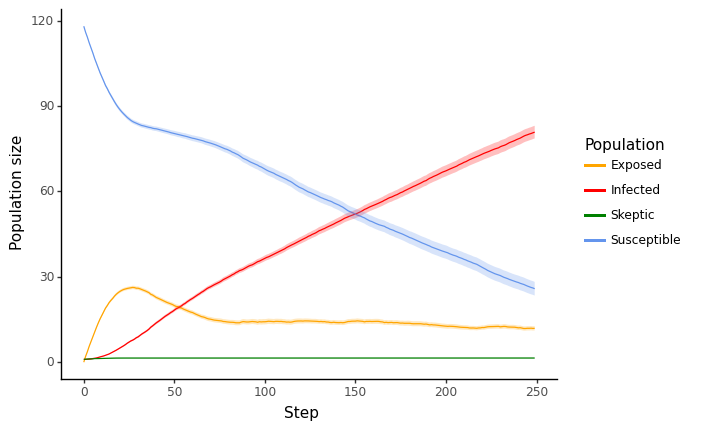

Run: 100%|██████████| 100/100 [02:45<00:00,  1.66s/it]


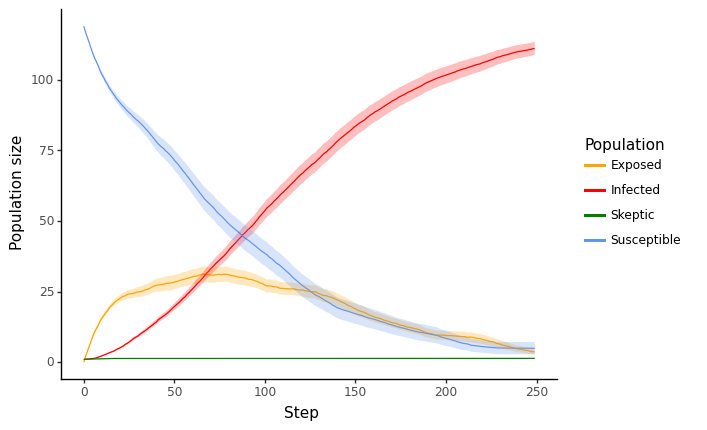

Run: 100%|██████████| 100/100 [02:46<00:00,  1.66s/it]


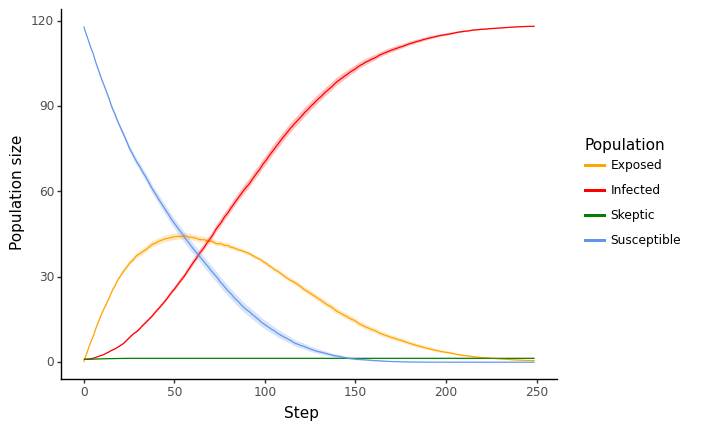

Run: 100%|██████████| 100/100 [02:32<00:00,  1.53s/it]


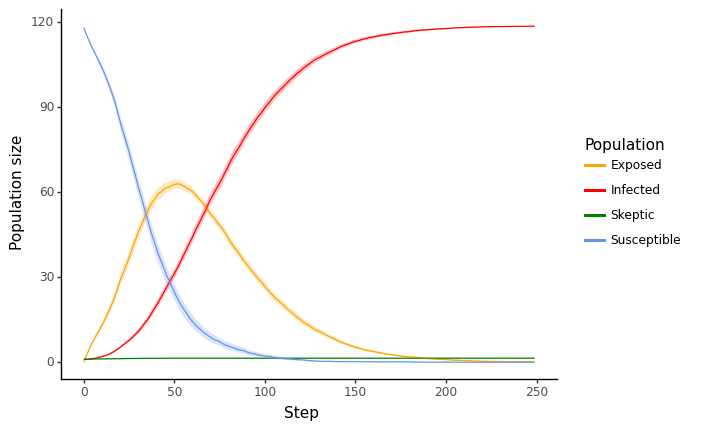

In [32]:
dynamics, network = ModelType.SEIZ, NetworkType.CAVEMAN 
run_trajectories(dynamics, network, n_replicates = replicates_u)
dynamics, network = ModelType.SEIZ, NetworkType.WINDMILL 
run_trajectories(dynamics, network, n_replicates = replicates_u)
dynamics, network = ModelType.SEIZ, NetworkType.SMALLWORLD 
run_trajectories(dynamics, network, n_replicates = replicates_u)
dynamics, network = ModelType.SEIZ, NetworkType.BARABASI_ALBERT 
run_trajectories(dynamics, network, n_replicates = replicates_u)


### Params2

In [33]:
 # TODO: Simulation parameters

params = {
    ModelType.SEIZ: { # TODO
        'model': SEIZModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=0.03,
            prob_S_with_Z=0.03,
            prob_E_to_I=0.01
        ),
        'agent': None,
        'state_labels': [("Susceptible", 'cornflowerblue'), ("Exposed", "orange"), ("Skeptic","green"), ("Infected",'red')]
    },

}

network_params = {
    # Parameters are chosen such that all networks have similar density
    NetworkType.CAVEMAN: (6, 20),  # (l, k)
    NetworkType.WINDMILL: (8, 16),  # (n, k)
    NetworkType.SMALLWORLD: (120, 20, 0.05),
    NetworkType.BARABASI_ALBERT: (120, 21,84,0.96)  # (n, m1, m2, p)
}

Run: 100%|██████████| 100/100 [02:20<00:00,  1.40s/it]


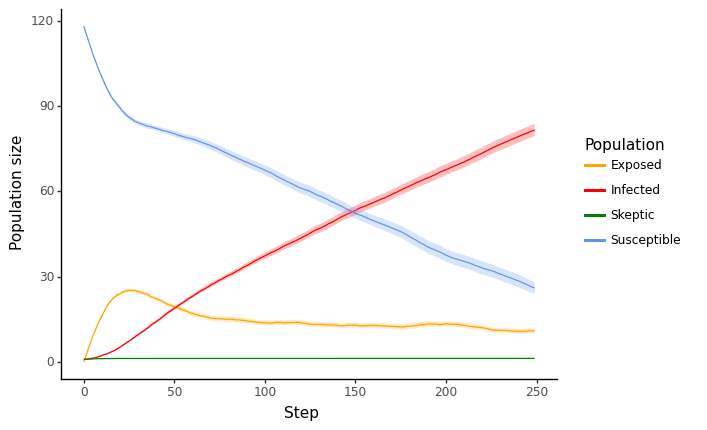

Run: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


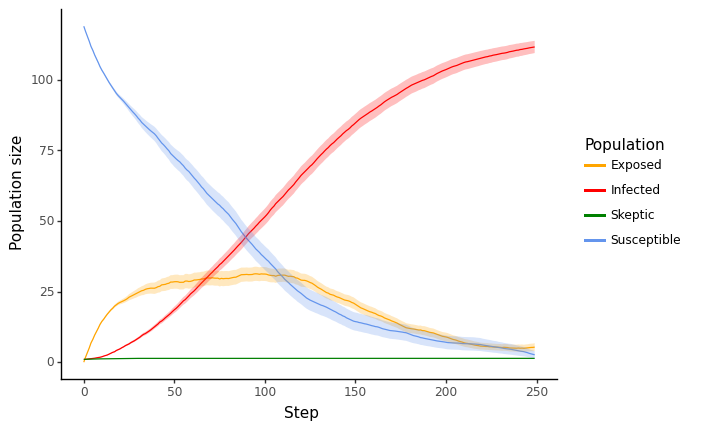

Run: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


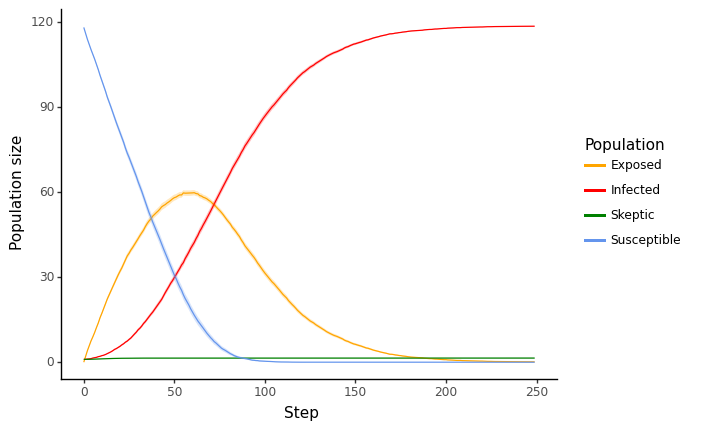

Run: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


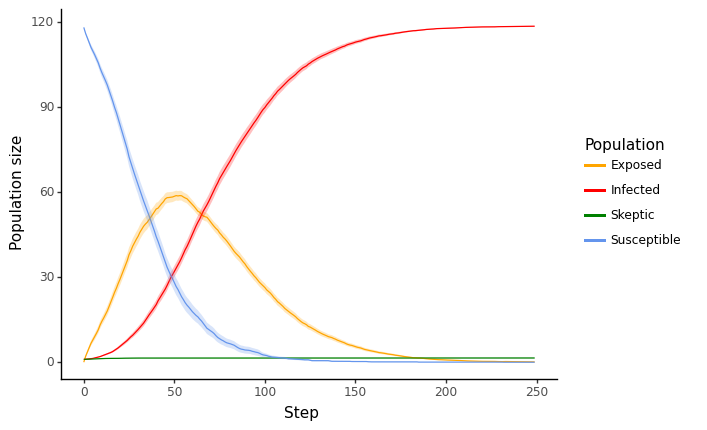

In [34]:
dynamics, network = ModelType.SEIZ, NetworkType.CAVEMAN 
run_trajectories(dynamics, network, n_replicates = replicates_u)
dynamics, network = ModelType.SEIZ, NetworkType.WINDMILL 
run_trajectories(dynamics, network, n_replicates = replicates_u)
dynamics, network = ModelType.SEIZ, NetworkType.SMALLWORLD 
run_trajectories(dynamics, network, n_replicates = replicates_u)
dynamics, network = ModelType.SEIZ, NetworkType.BARABASI_ALBERT 
run_trajectories(dynamics, network, n_replicates = replicates_u)

### Params3

In [35]:
 # TODO: Simulation parameters

params = {
    ModelType.SEIZ: { # TODO
        'model': SEIZModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=0.03,
            prob_S_with_Z=0.03,
            prob_E_to_I=0.01
        ),
        'agent': None,
        'state_labels': [("Susceptible", 'cornflowerblue'), ("Exposed", "orange"), ("Skeptic","green"), ("Infected",'red')]
    },

}

network_params = {
    # Parameters are chosen such that all networks have similar density
    NetworkType.CAVEMAN: (6, 20),  # (l, k)
    NetworkType.WINDMILL: (8, 16),  # (n, k)
    NetworkType.SMALLWORLD: (120, 20, 0.1),
    NetworkType.BARABASI_ALBERT: (120, 27,108,0.32)  # (n, m1, m2, p)
}

Run: 100%|██████████| 100/100 [02:17<00:00,  1.38s/it]


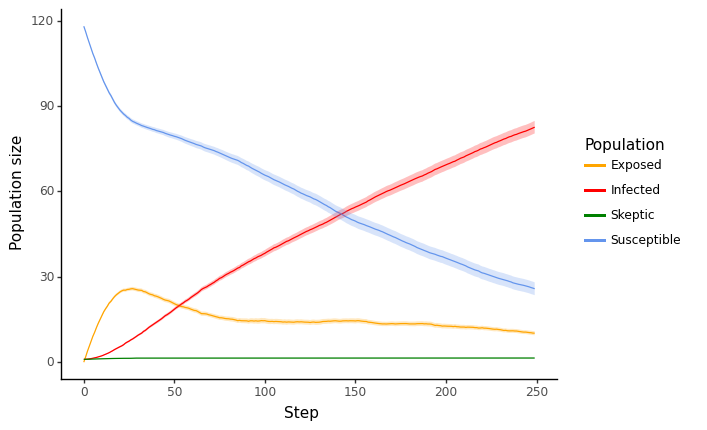

Run: 100%|██████████| 100/100 [02:41<00:00,  1.61s/it]


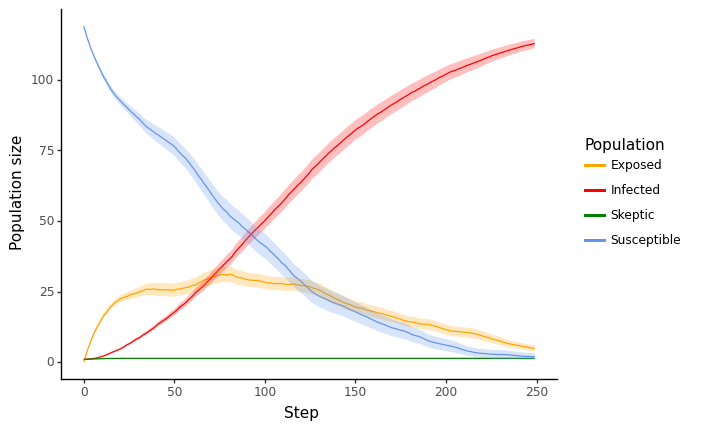

Run: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


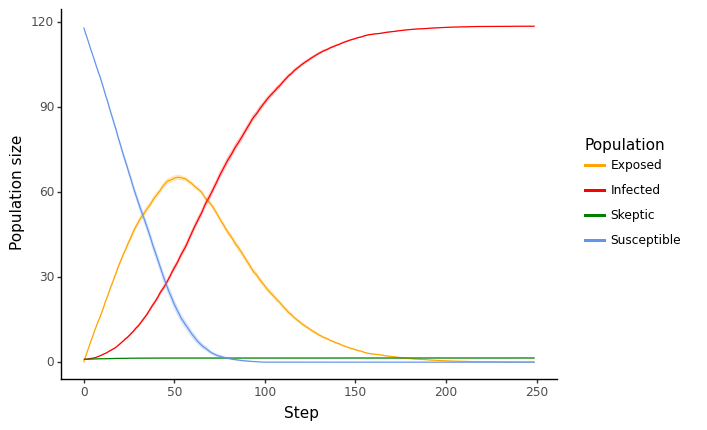

Run: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


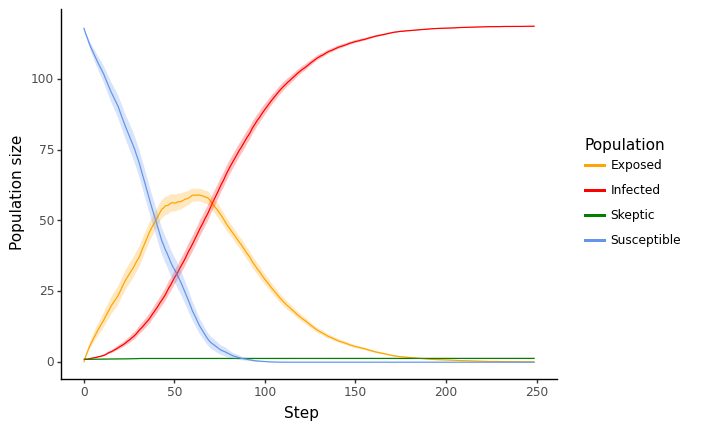

In [36]:
dynamics, network = ModelType.SEIZ, NetworkType.CAVEMAN 
run_trajectories(dynamics, network, n_replicates = replicates_u)
dynamics, network = ModelType.SEIZ, NetworkType.WINDMILL 
run_trajectories(dynamics, network, n_replicates = replicates_u)
dynamics, network = ModelType.SEIZ, NetworkType.SMALLWORLD 
run_trajectories(dynamics, network, n_replicates = replicates_u)
dynamics, network = ModelType.SEIZ, NetworkType.BARABASI_ALBERT 
run_trajectories(dynamics, network, n_replicates = replicates_u)

### Params4

In [37]:
 # TODO: Simulation parameters

params = {
    ModelType.SEIZ: { # TODO
        'model': SEIZModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=0.03,
            prob_S_with_Z=0.03,
            prob_E_to_I=0.01
        ),
        'agent': None,
        'state_labels': [("Susceptible", 'cornflowerblue'), ("Exposed", "orange"), ("Skeptic","green"), ("Infected",'red')]
    },

}

network_params = {
    # Parameters are chosen such that all networks have similar density
    NetworkType.CAVEMAN: (3,40),  # (l, k)
    NetworkType.WINDMILL: (3,41),  # (n, k)
    NetworkType.SMALLWORLD: (120, 40,0),
    NetworkType.BARABASI_ALBERT: (120,15,60,0.6)  # (n, m1, m2, p)
}

Run: 100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


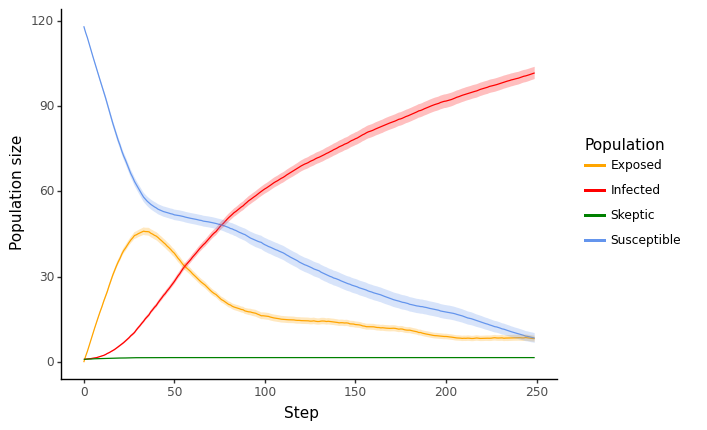

Run: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


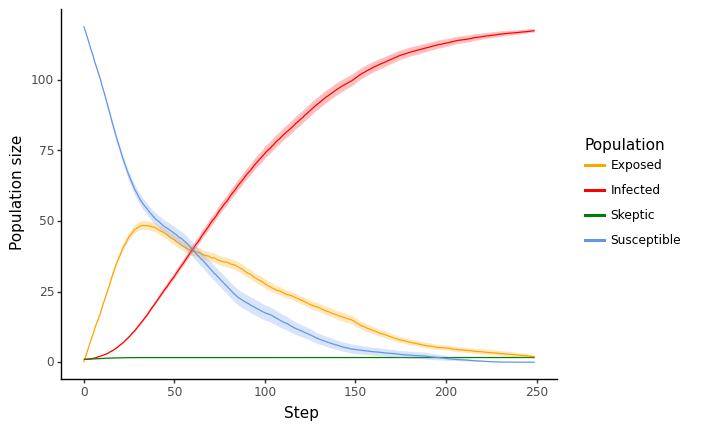

Run: 100%|██████████| 100/100 [02:41<00:00,  1.61s/it]


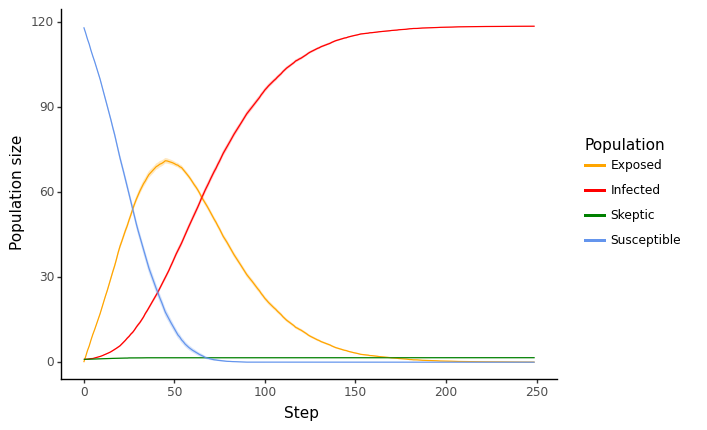

Run: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


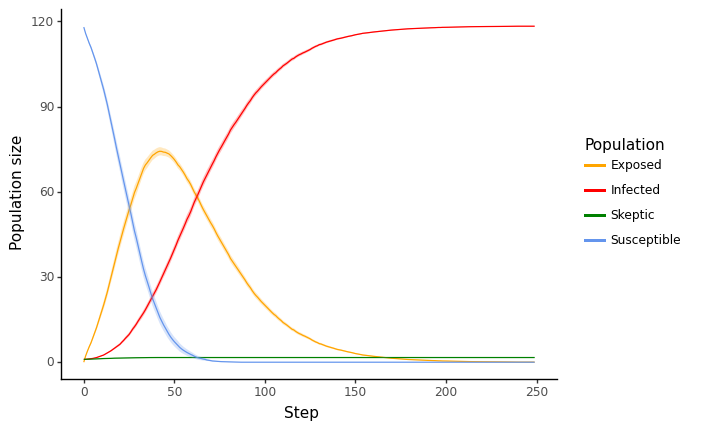

In [38]:
dynamics, network = ModelType.SEIZ, NetworkType.CAVEMAN 
run_trajectories(dynamics, network, n_replicates = replicates_u)
dynamics, network = ModelType.SEIZ, NetworkType.WINDMILL 
run_trajectories(dynamics, network, n_replicates = replicates_u)
dynamics, network = ModelType.SEIZ, NetworkType.SMALLWORLD 
run_trajectories(dynamics, network, n_replicates = replicates_u)
dynamics, network = ModelType.SEIZ, NetworkType.BARABASI_ALBERT 
run_trajectories(dynamics, network, n_replicates = replicates_u)

### Params 5

In [39]:
 # TODO: Simulation parameters

params = {
    ModelType.SEIZ: { # TODO
        'model': SEIZModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=0.03,
            prob_S_with_Z=0.03,
            prob_E_to_I=0.01
        ),
        'agent': None,
        'state_labels': [("Susceptible", 'cornflowerblue'), ("Exposed", "orange"), ("Skeptic","green"), ("Infected",'red')]
    },

}

network_params = {
    # Parameters are chosen such that all networks have similar density
    NetworkType.CAVEMAN: (3,40),  # (l, k)
    NetworkType.WINDMILL: (3,41),  # (n, k)
    NetworkType.SMALLWORLD: (120, 40,0.05),
    NetworkType.BARABASI_ALBERT: (120,21,84,0.4)  # (n, m1, m2, p)
}

Run: 100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


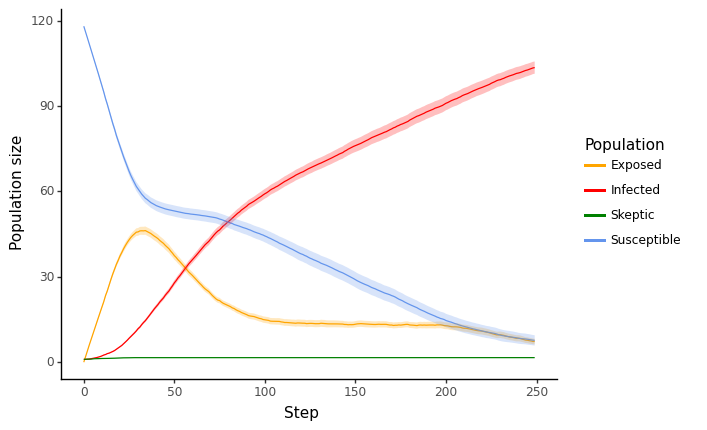

Run: 100%|██████████| 100/100 [02:43<00:00,  1.64s/it]


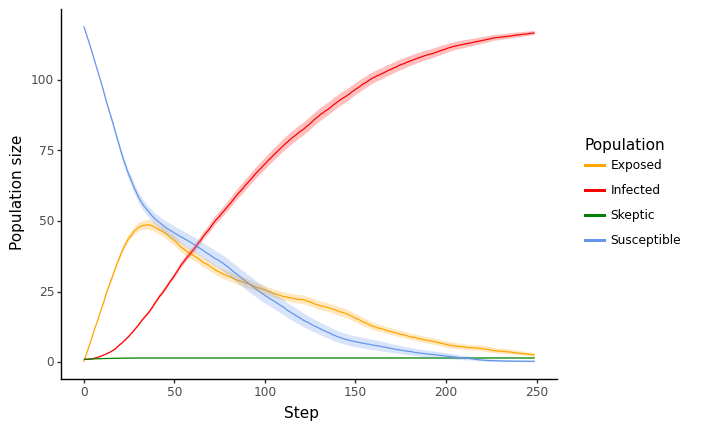

Run: 100%|██████████| 100/100 [02:44<00:00,  1.64s/it]


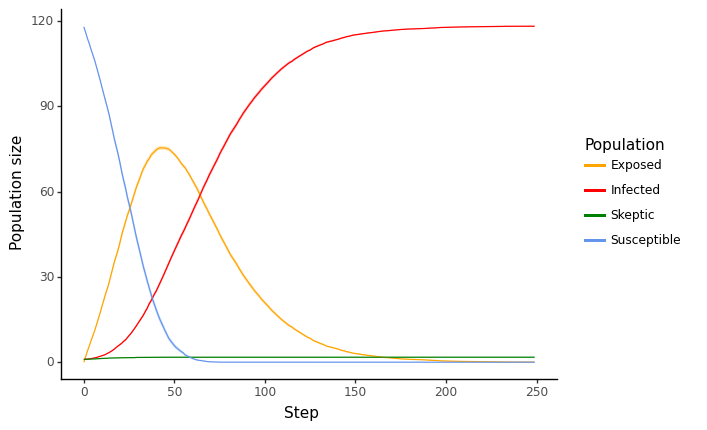

Run: 100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


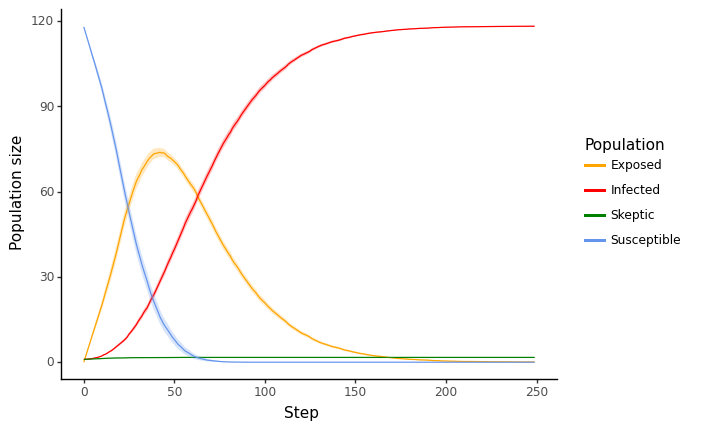

In [40]:
dynamics, network = ModelType.SEIZ, NetworkType.CAVEMAN 
run_trajectories(dynamics, network, n_replicates = replicates_u)
dynamics, network = ModelType.SEIZ, NetworkType.WINDMILL 
run_trajectories(dynamics, network, n_replicates = replicates_u)
dynamics, network = ModelType.SEIZ, NetworkType.SMALLWORLD 
run_trajectories(dynamics, network, n_replicates = replicates_u)
dynamics, network = ModelType.SEIZ, NetworkType.BARABASI_ALBERT 
run_trajectories(dynamics, network, n_replicates = replicates_u)

### Params 6

In [41]:
 # TODO: Simulation parameters

params = {
    ModelType.SEIZ: { # TODO
        'model': SEIZModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=0.03,
            prob_S_with_Z=0.03,
            prob_E_to_I=0.01
        ),
        'agent': None,
        'state_labels': [("Susceptible", 'cornflowerblue'), ("Exposed", "orange"), ("Skeptic","green"), ("Infected",'red')]
    },

}

network_params = {
    # Parameters are chosen such that all networks have similar density
    NetworkType.CAVEMAN: (3,40),  # (l, k)
    NetworkType.WINDMILL: (3,41),  # (n, k)
    NetworkType.SMALLWORLD: (120, 40,0.1),
    NetworkType.BARABASI_ALBERT: (120,27,108,0)  # (n, m1, m2, p)
}

Run: 100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


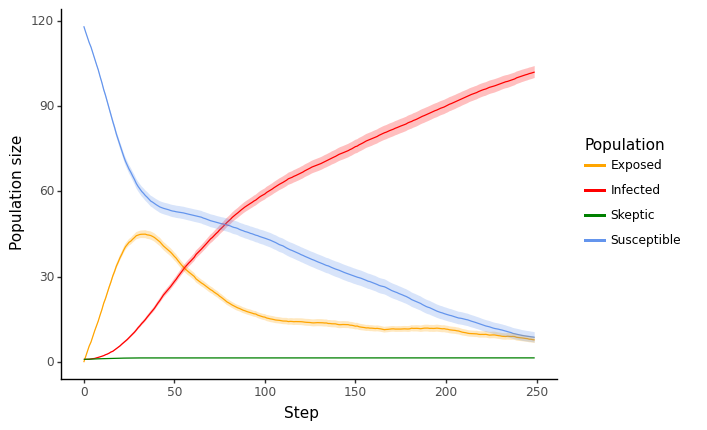

Run: 100%|██████████| 100/100 [02:46<00:00,  1.66s/it]


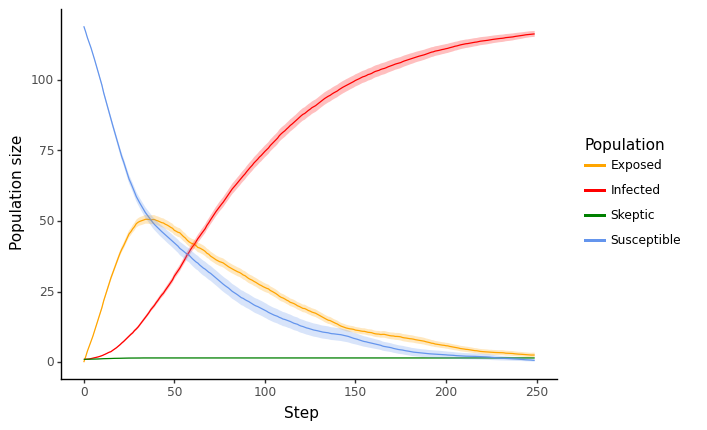

Run: 100%|██████████| 100/100 [02:41<00:00,  1.61s/it]


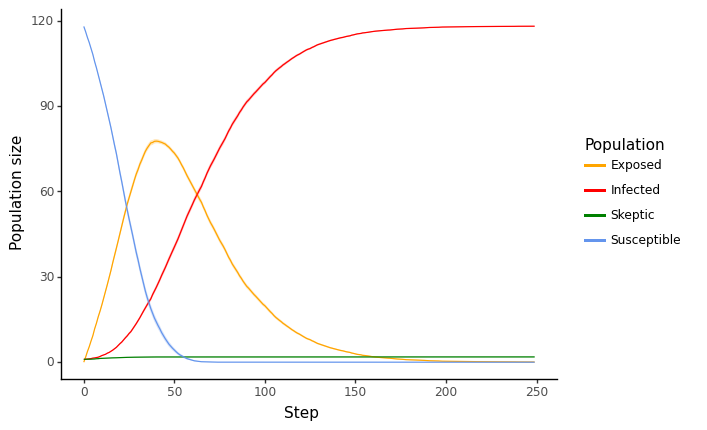

Run: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it]


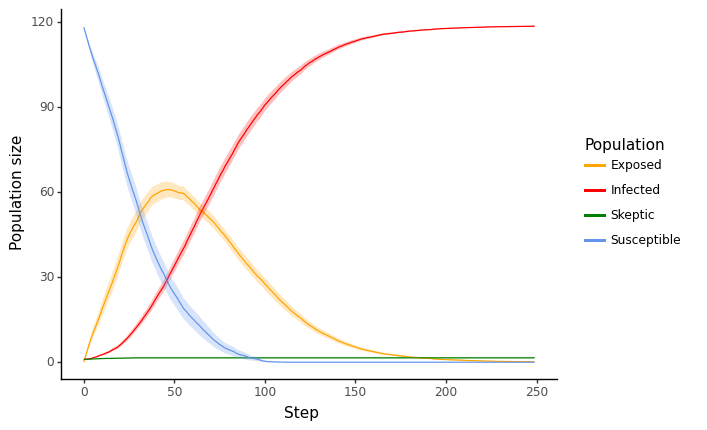

In [42]:
dynamics, network = ModelType.SEIZ, NetworkType.CAVEMAN 
run_trajectories(dynamics, network, n_replicates = replicates_u)
dynamics, network = ModelType.SEIZ, NetworkType.WINDMILL 
run_trajectories(dynamics, network, n_replicates = replicates_u)
dynamics, network = ModelType.SEIZ, NetworkType.SMALLWORLD 
run_trajectories(dynamics, network, n_replicates = replicates_u)
dynamics, network = ModelType.SEIZ, NetworkType.BARABASI_ALBERT 
run_trajectories(dynamics, network, n_replicates = replicates_u)